# Latent Space Variational Geologic  Inversion from Multi-Source Dynamic Data
### Misael M. Morales, 2024
***

In [2]:
# Load my project packages
from utils_2d import *
K.clear_session()

In [3]:
# Check tensorflow GPU settings
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.15.0
# GPU available: 1
CUDA: 12.2 | cuDNN: 8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***
# Load all data and Visualize

In [4]:
### Load individual datasets from simulations
timestamps, poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut = load_initial_data()

Perm: (1000, 128, 128) | Poro: (1000, 128, 128) | Channels: (1000, 128, 128) | Pressure: (1000, 45, 128, 128) | Saturation: (1000, 45, 128, 128)
OPR: (1000, 45, 3) | WPR: (1000, 45, 3) | WCUT: (1000, 45, 3) | Timestamps: (45,)


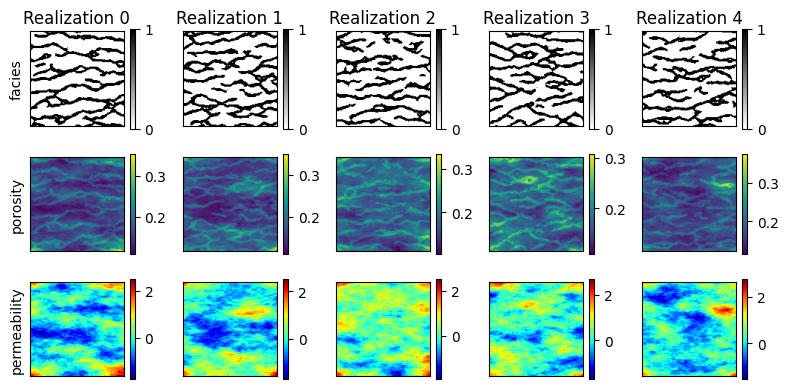

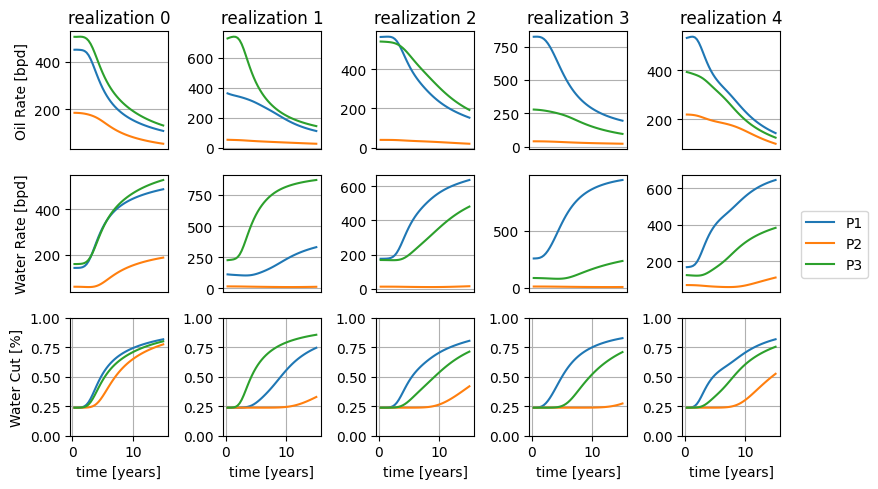

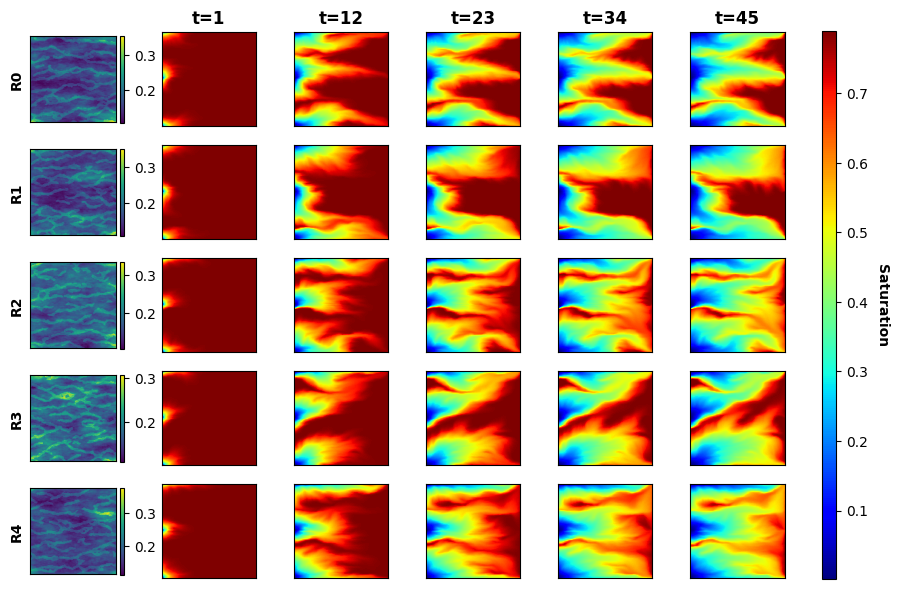

In [84]:
plot_static(poro, perm, channels, multiplier=1, ncols=5, inv_flag=False, figsize=(8,4))
plot_data(timestamps, well_opr, well_wpr, well_wcut, multiplier=1, ncols=5, figsize=(8,5), bbox=(1.1, 0.5))
plot_dynamic(poro, saturation, multiplier=1, nrows=5, ncols=5, figsize=(9,6))
# make_dynamic_animation(poro, [pressure,saturation])

***
# Data Processing
Load pre-existing data

Normalization, concatenate features and targets, train-test split

In [85]:
### (a) To split and normalize data into (x,y,w):
# X_data, y_data, w_data = split_xyw(poro, perm, channels, pressure, saturation, well_opr, well_wpr, well_wcut)

### (b) To load pre-computed, normalized (X,y,w,t):
X_data, y_data, w_data, timestamps = load_xywt()

X shape: (1000, 45, 128, 128, 2) | w shape: (1000, 45, 3, 3) 
y shape: (1000, 128, 128, 3) | t shape: (45,)


In [107]:
# Perform train-test split
xarr, yarr, warr, locs = my_train_test_split(X_data, y_data, w_data, nobs=30, equigrid=False)
[X_train,X_test], [y_train,y_test], [w_train,w_test], [randx,randy] = xarr, yarr, warr, locs

X_train shape: (700, 45, 30, 2)   | X_test shape: (300, 45, 30, 2)
w_train shape: (700, 45, 3, 3)    | w_test shape: (300, 45, 3, 3)
y_train shape: (700, 128, 128, 3) | y_test shape: (300, 128, 128, 3)


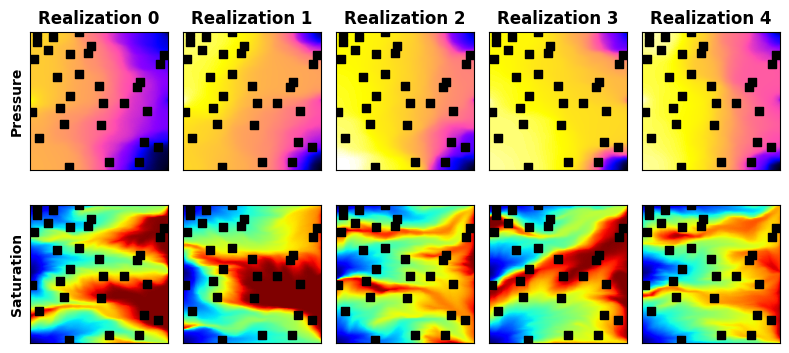

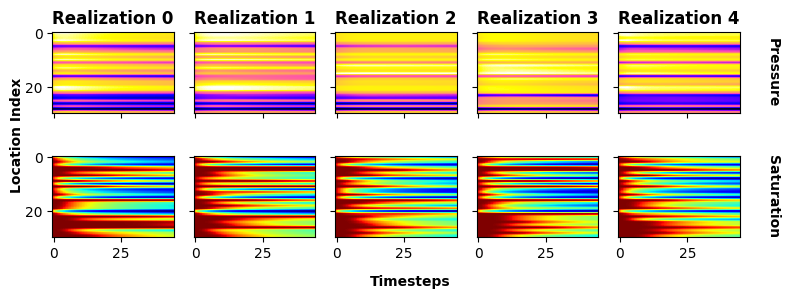

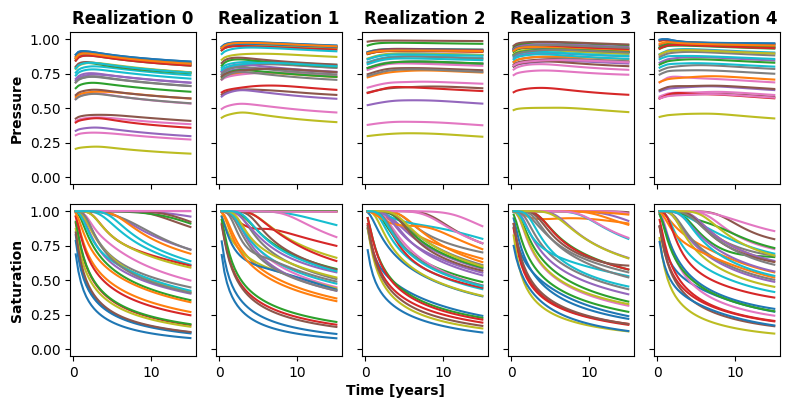

In [108]:
# Visualize X-samples
plot_X_img_observation(X_data, randx, randy, ncols=5, figsize=(8,4))
plot_X_observation(X_train, ncols=5, figsize=(8,3), labelpad=-110)
plot_X_line_observation(X_train, timestamps, ncols=5, figsize=(8,4))

***
# Build, Compile, Train, and Predict with AutoEncoder Models
Run Train/Test Predictions

2024-03-21 21:12:04.703918: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-21 21:12:04.815976: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-03-21 21:12:04.997274: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: Permission denied
2024-03-21 21:12:07.841136: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f35bf6cb840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-21 21:12:07.841175: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-03-21 21:12:07.853464: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711073527.940324    1856 device_compiler.h:186] Compiled 

# Parameters: 40,238 | Training time: 2.98 minutes
# Parameters: 5,610,120 | Training time: 0.38 minutes
# Parameters: 308,025 | Training time: 0.34 minutes


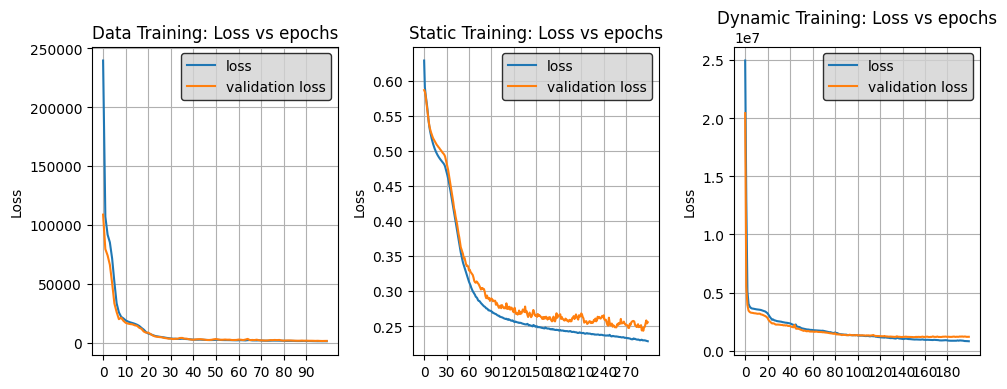

In [109]:
static_enc,  static_dec,  static_ae,  static_fit  = make_static_ae(y_train)
dynamic_enc, dynamic_dec, dynamic_ae, dynamic_fit = make_dynamic_ae(X_train)
data_enc,    data_dec,    data_ae,    data_fit    = make_data_ae(w_train)
plot_loss_all(static_fit, data_fit, dynamic_fit)

10/10 [==============================] - 0s 14ms/step
Train MSE: 3.03e-02 | Test MSE: 3.03e-02
Train SSIM: 81.72 | Test SSIM: 81.30


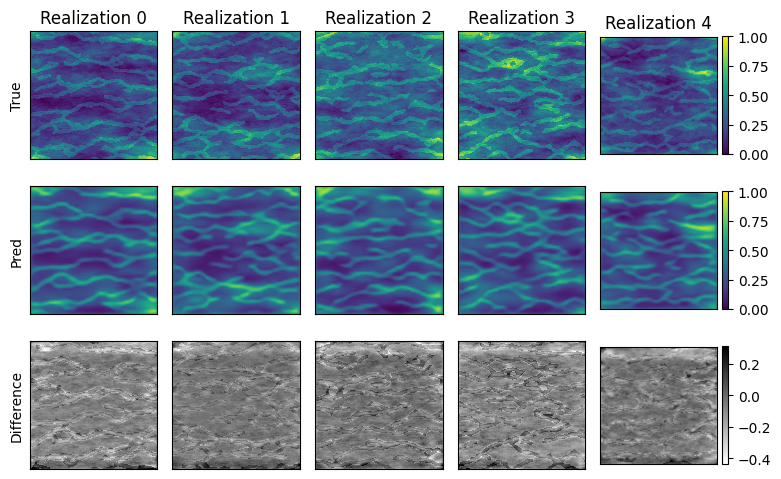

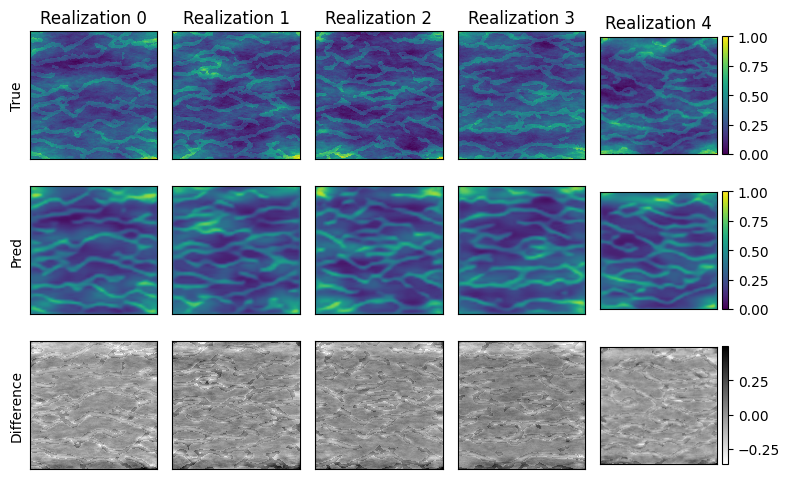

In [120]:
y_train_pred, y_test_pred = make_ae_prediction(y_train, y_test, static_ae)
plot_static_results([y_train, y_test], [y_train_pred, y_test_pred], train_or_test='train', ncols=5, channel_select=0, figsize=(8,5))
plot_static_results([y_train, y_test], [y_train_pred, y_test_pred], train_or_test='test', ncols=5, channel_select=0, figsize=(8,5))

10/10 [==============================] - 0s 3ms/step
Train MSE: 5.32e-04 | Test MSE: 5.32e-04
Image data must have shape at least (7x7) for ssim calculation


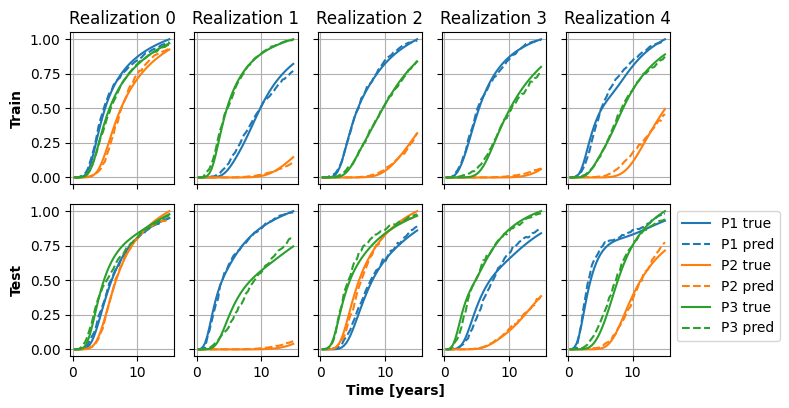

In [183]:
w_train_pred, w_test_pred = make_ae_prediction(w_train, w_test, data_ae)
plot_data_results(timestamps, w_train, w_test, w_train_pred, w_test_pred, channel_select=2, ncols=5, figsize=(8,4))

10/10 [==============================] - 0s 3ms/step
Train MSE: 3.15e-03 | Test MSE: 3.15e-03
Train SSIM: 94.93 | Test SSIM: 92.92


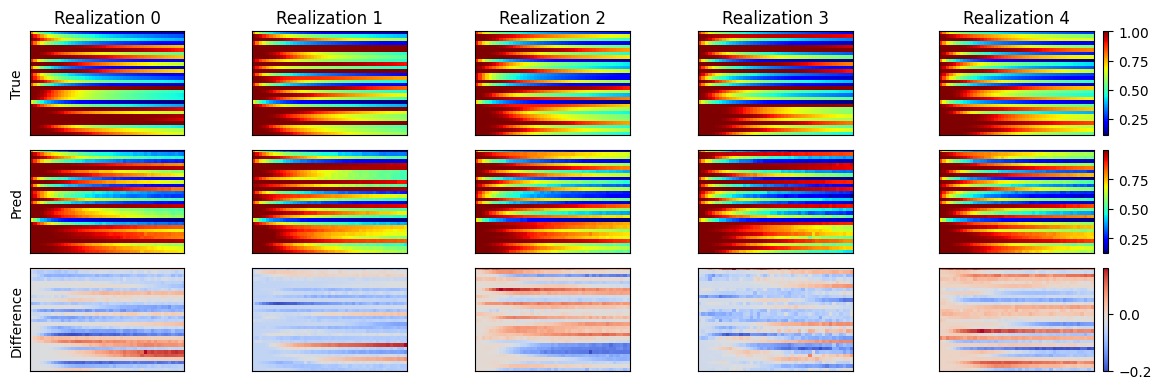

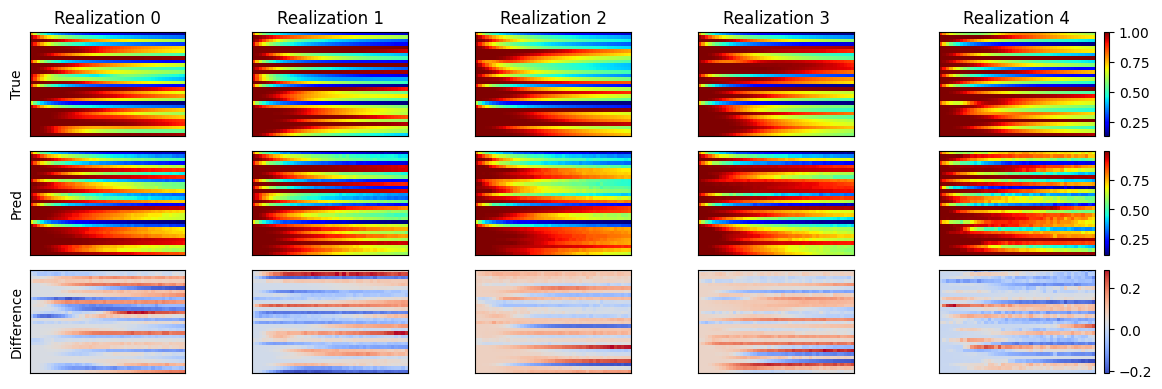

In [189]:
X_train_pred, X_test_pred = make_ae_prediction(X_train, X_test, dynamic_ae)
plot_dynamic_results([X_train, X_test], [X_train_pred, X_test_pred], train_or_test='train', ncols=5)
plot_dynamic_results([X_train, X_test], [X_train_pred, X_test_pred], train_or_test='test', ncols=5)

***
### Join train-test data for full transfer learning of latent regressors

In [190]:
X_full, w_full, y_full = make_full_traintest(X_train, X_test, w_train, w_test, y_train, y_test)

X_full: (1000, 45, 30, 2) | w_full: (1000, 45, 3, 3) | y_full: (1000, 128, 128, 3)


***
# Build, Compile, Train, and Predict with Latent-Inversion Network

# Parameters: 62,959,895 | Training time: 4.28 minutes


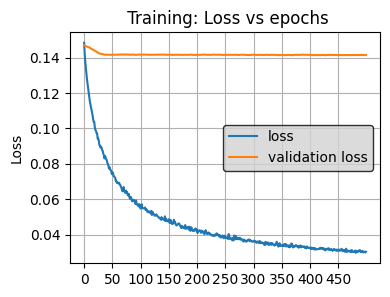

In [191]:
inv, inv_fit = make_inv_regressor(X_full, w_full, y_full, dynamic_enc, data_enc, static_dec)
plot_loss(inv_fit, figsize=(4,3), savefig=True, fname='inverse_reg_trainingperformance')

10/10 [==============================] - 0s 18ms/step
Train MSE: 2.37e-02 | Test MSE: 1.02e-01
Train SSIM: 80.82 | Test SSIM: 37.32


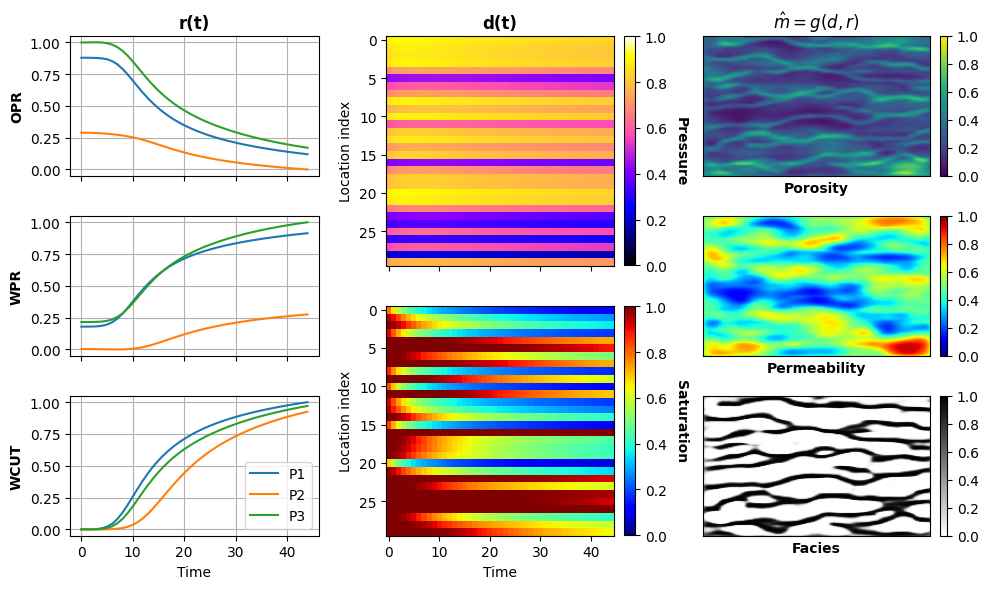

In [192]:
inv_train, inv_test = make_inv_prediction(inv, [X_train, X_test], [w_train, w_test], [y_train, y_test])
inv_y = {'train':inv_train, 'test':inv_test}
plot_inv_latent_dashboard(X_full, w_full, inv_train)

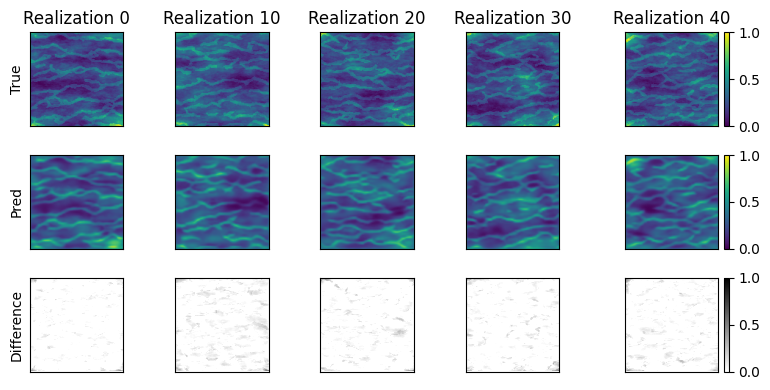

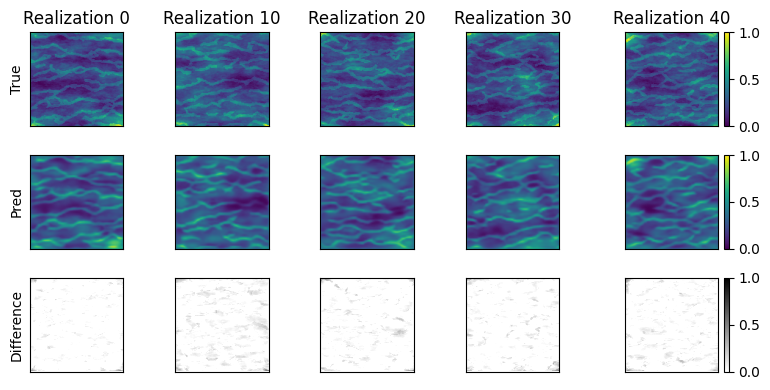

In [195]:
plot_inversion_result([y_train, y_test], [inv_train, inv_test], train_or_test='train', ncols=5, figsize=(8,4))
plot_inversion_result([y_train, y_test], [inv_train, inv_test], train_or_test='train', ncols=5, figsize=(8,4))

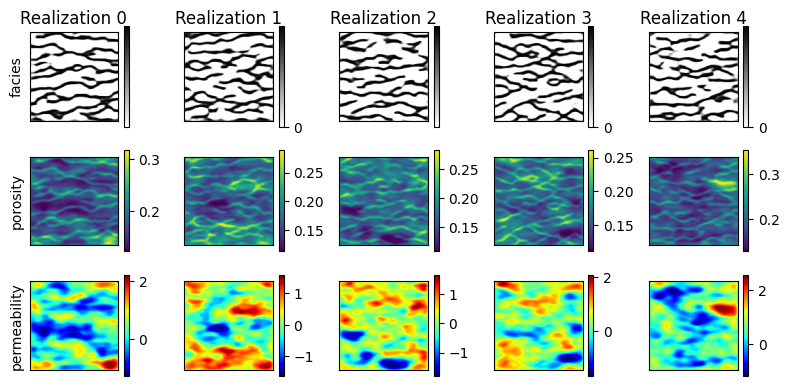

In [197]:
poro_hat, perm_hat, channels_hat = make_inv_backnorm([inv_train, inv_test], [poro, perm, channels])
plot_static(poro_hat, perm_hat, channels_hat, ncols=5, figsize=(8,4), inv_flag=True)

***
# Build, Compile, Train, and Predict with Latent-Forward Network

# Parameters: 20,889,152 | Training time: 0.67 minutes


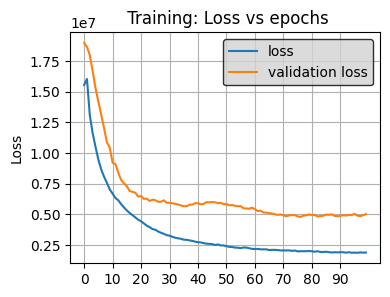

In [198]:
fwd, fwd_fit = make_fwd_regressor(X_full, w_full, y_full, dynamic_dec, data_dec, static_enc)
plot_loss(fwd_fit, figsize=(4,3), savefig=True, fname='forward_reg_trainingperformance')

10/10 [==============================] - 0s 11ms/step
X - MSE: Train 5.55e-03 | Test: 1.48e-02
w - MSE: Train 1.20e-03 | Test: 1.49e-02


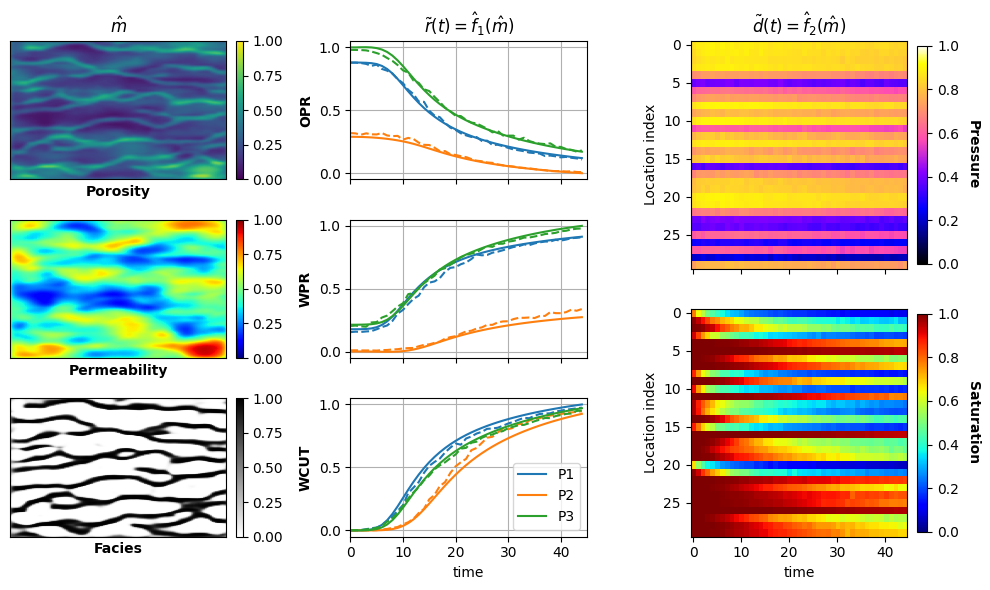

In [219]:
fwd_X, fwd_w = make_fwd_prediction(fwd, [X_train, X_test], [w_train, w_test], [y_train, y_test])
plot_fwd_latent_dashboard(w_full, np.concatenate([inv_train, inv_test],0), fwd_X['train'], fwd_w['train'])

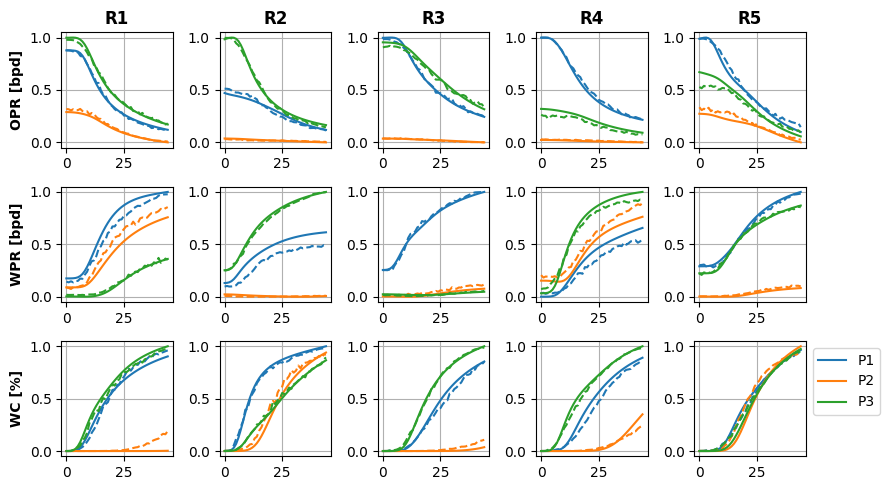

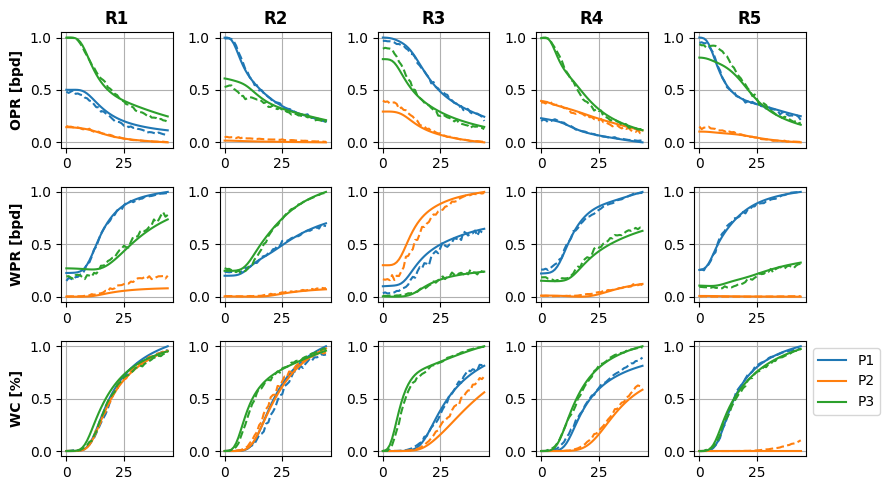

In [301]:
plot_fwd_results_data([w_train,w_test], fwd_w, train_or_test='train', ncols=5)
plot_fwd_results_data([w_train,w_test], fwd_w, train_or_test='test', ncols=5)

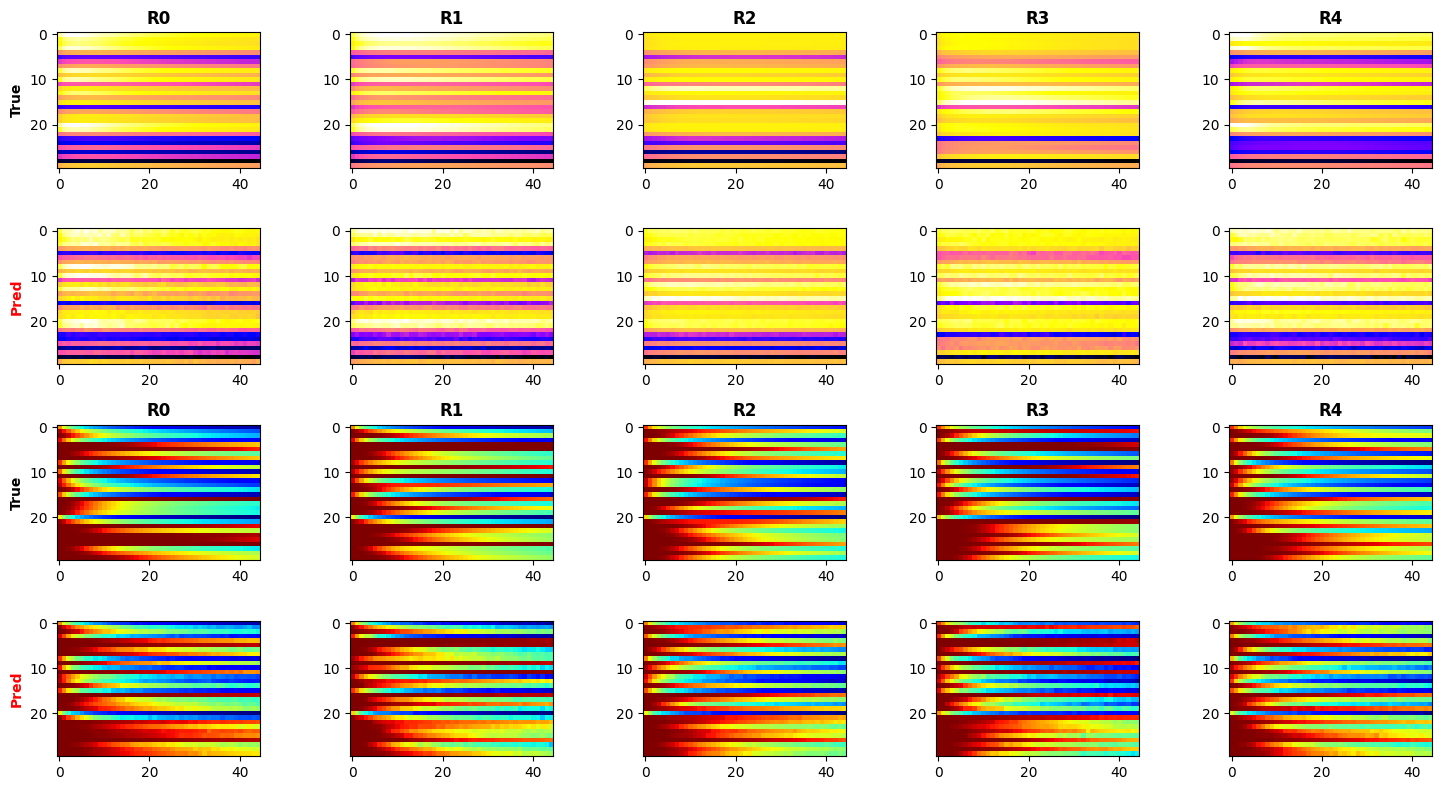

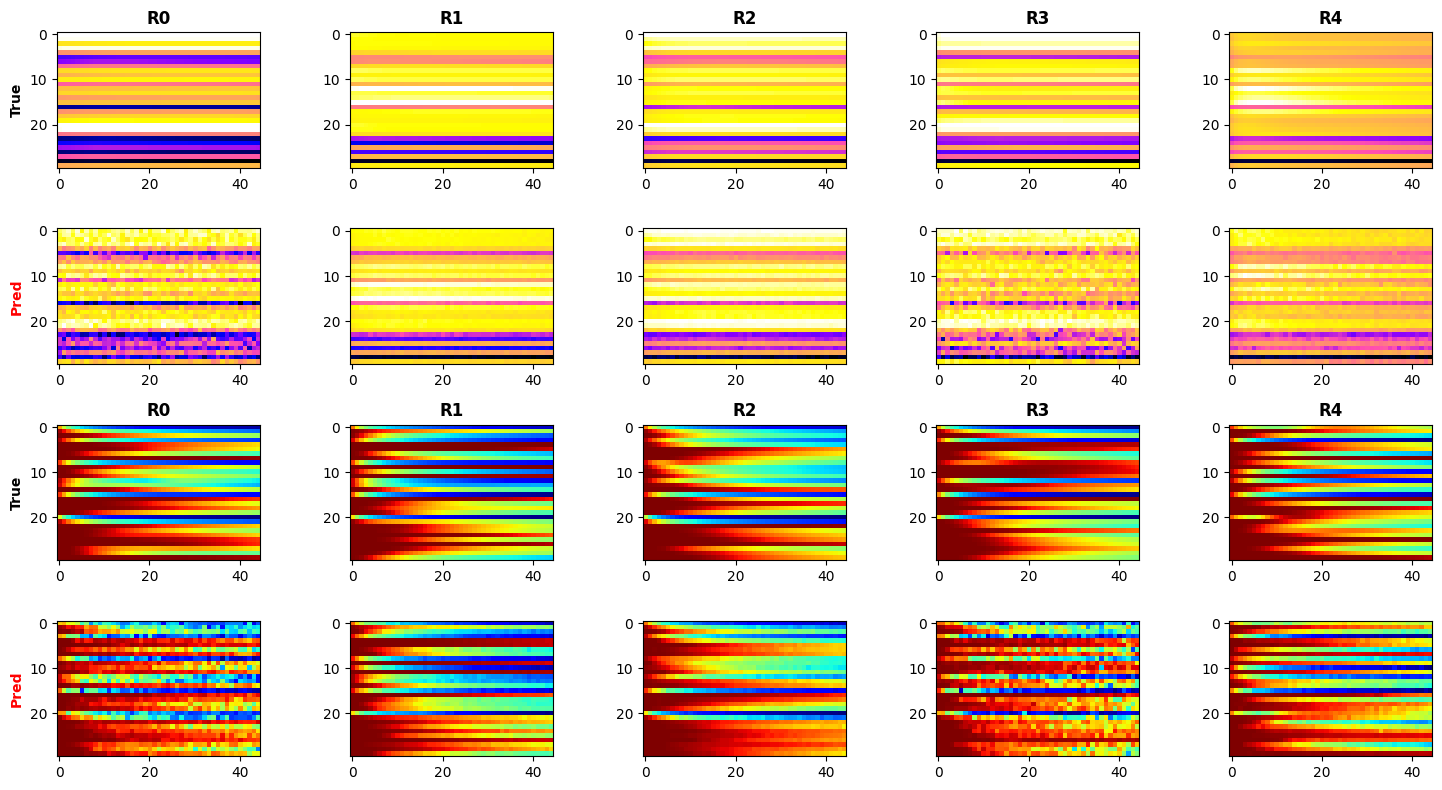

In [306]:
plot_fwd_results_dynamic([X_train,X_test], fwd_X, train_or_test='train')
plot_fwd_results_dynamic([X_train,X_test], fwd_X, train_or_test='test')

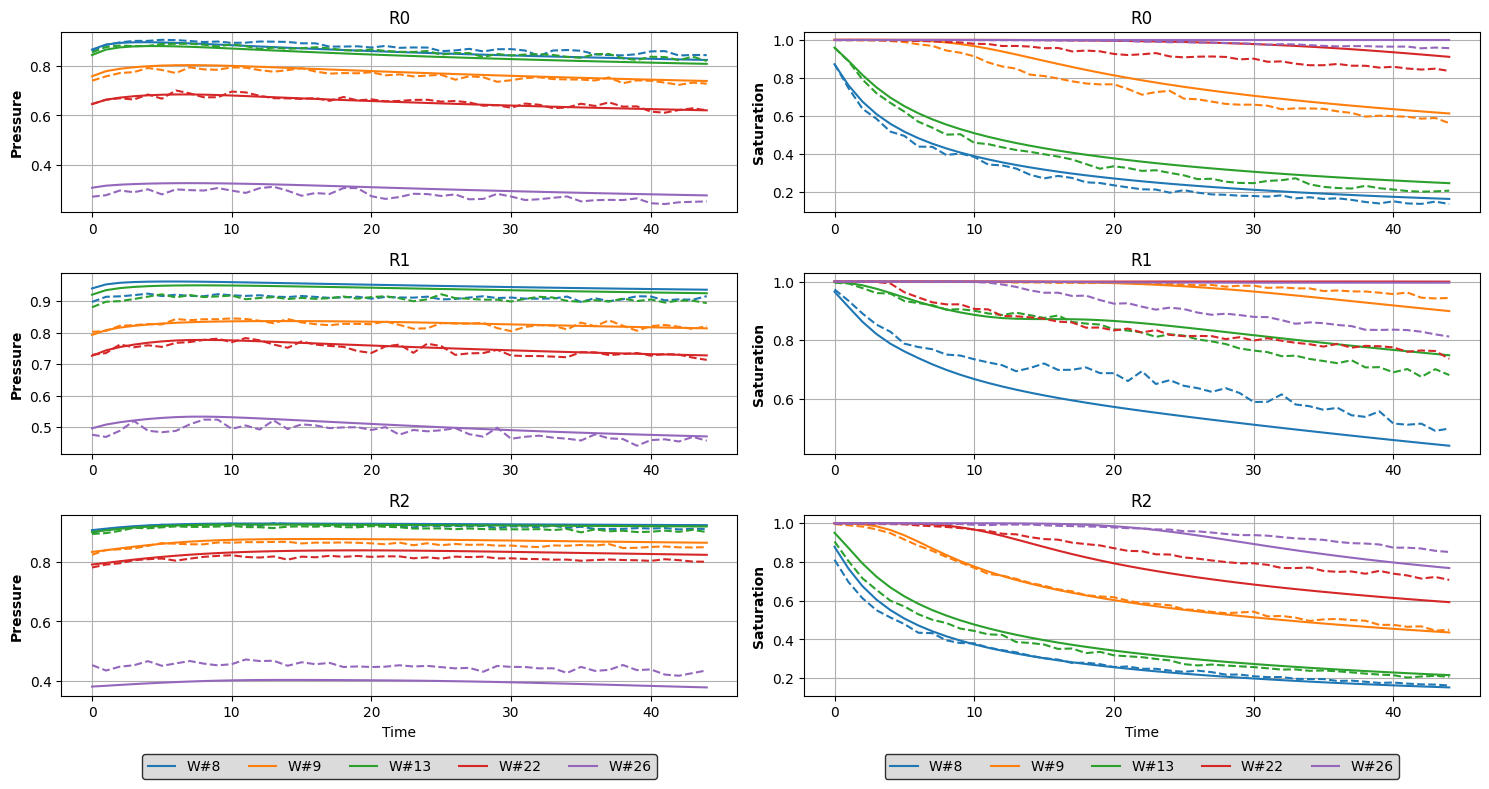

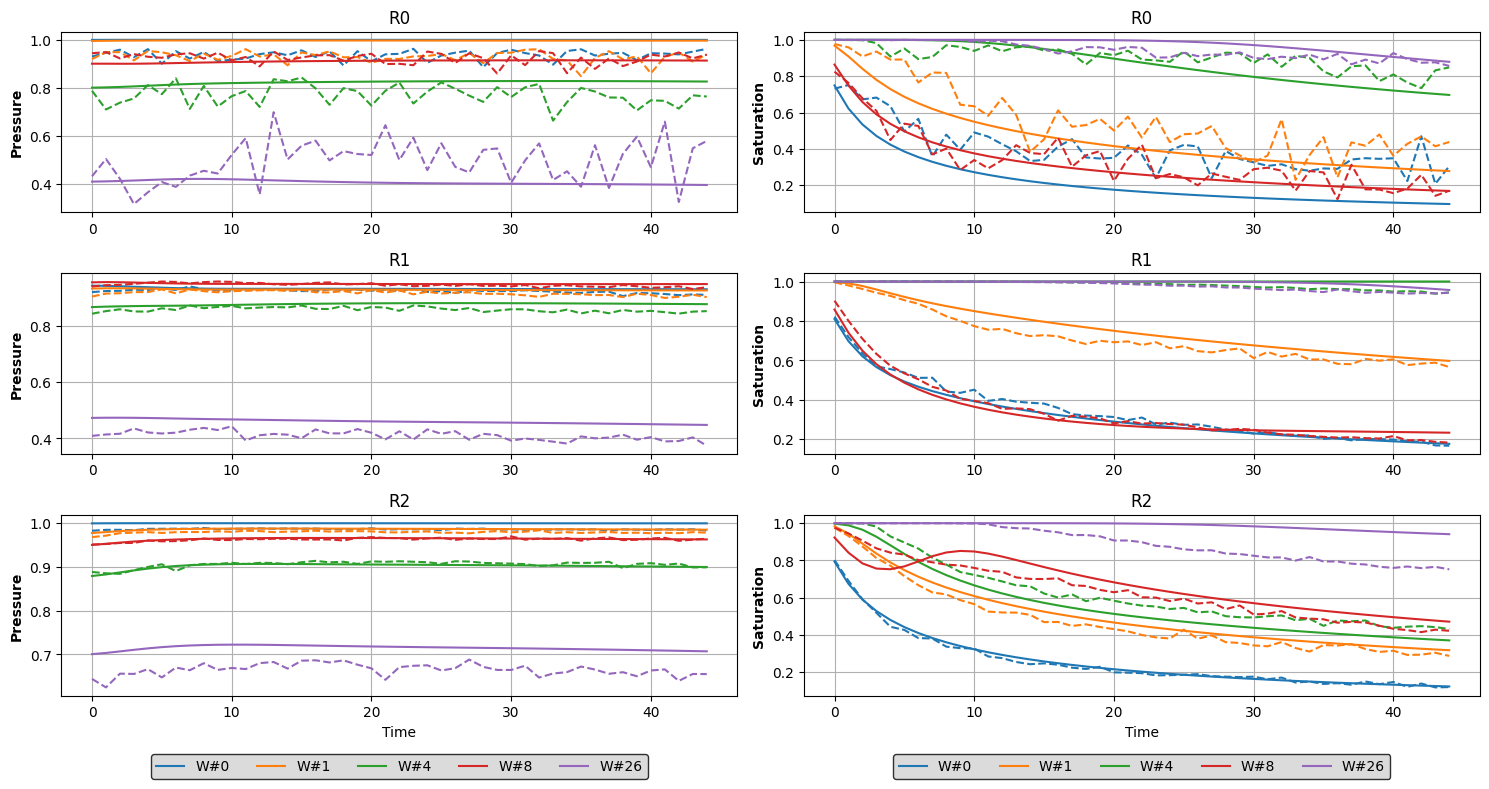

In [307]:
plot_fwd_results_dynamic_line([X_train,X_test], fwd_X, train_or_test='train')
plot_fwd_results_dynamic_line([X_train,X_test], fwd_X, train_or_test='test')

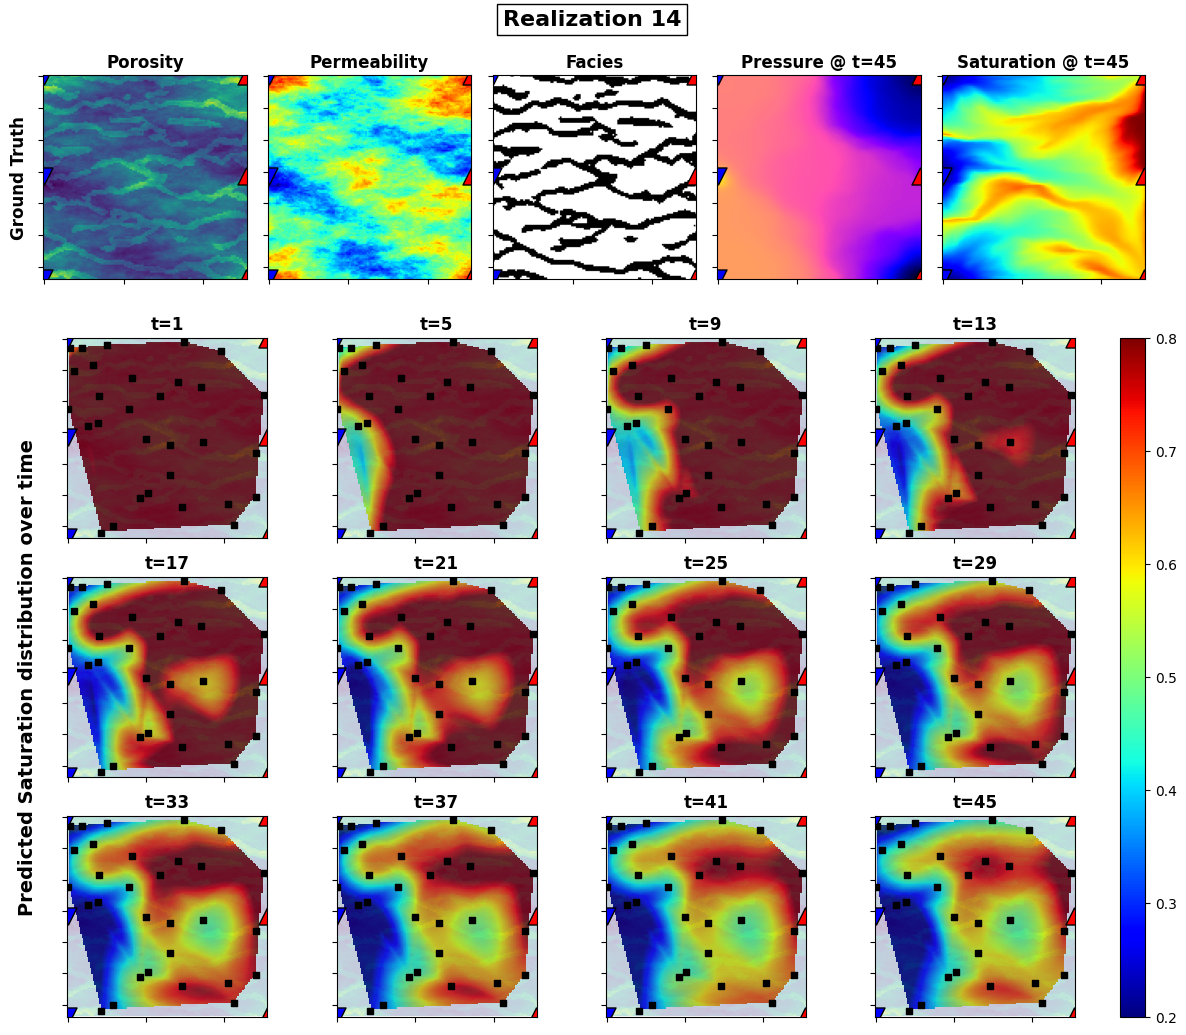

R2: -0.3869 | MSE: 0.8078
P  - True: [32.759 33.731 34.748] | Predicted: [31.934 33.64  35.018]
UQ - True: 1.9889 | Predicted: 3.0841


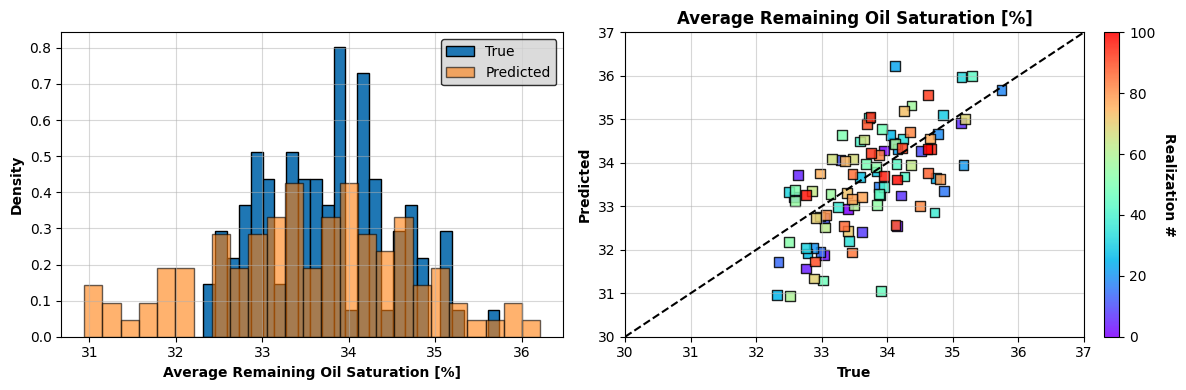

In [308]:
spatial_fwdX = fwd_latent_spatial_interpolation(fwd_X, locs=[randx,randy], train_or_test='train', n_obs=100)
plot_fwd_latent_map(spatial_fwdX, y_data, X_data, locs=[randx, randy], realization=14)
xcum_true, xcum_pred, uq = plot_fwd_resoil(X_data, spatial_fwdX, correction=0.75, cmap='rainbow')

***
### Save models

In [ ]:
save_models([static_enc,dynamic_enc,data_enc],
            [static_dec,dynamic_dec,data_dec],
            [static_ae,dynamic_ae,data_ae],
            [inv, fwd])

***
# END